# Handwritten digit Classifier

# **Classification**

In [ ]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False)

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [ ]:
X, y = mnist.data, mnist.target
y

array(['5', '0', '4', ..., '4', '5', '6'], dtype=object)

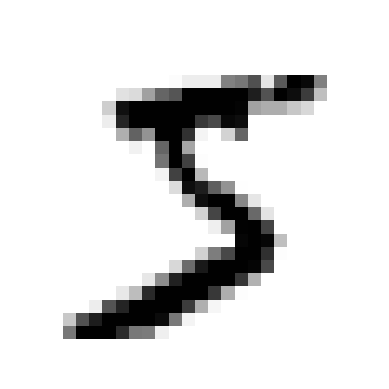

In [ ]:
import matplotlib.pyplot as plt
def plot_digit(image_data):
  image = image_data.reshape(28, 28)
  plt.imshow(image, cmap="binary")
  plt.axis("off")
some_digit = X[0]
plot_digit(some_digit)
plt.show()

In [ ]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [ ]:
# creating the target vectors for binary classifier
y_train_5 = (y_train == '5')
y_test_5 = (y_test == '5')

In [ ]:
#pick a classifier(SGD-Classifier) and train it
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
# sgd_clf.fit(X_train, y_train_5) #for binary classification
sgd_clf.fit(X_train, y_train) #for multiclass classification

SGDClassifier(random_state=42)

### let's make multiclass classification

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score #Measuring models performance Using Cross-Validation
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype("float64"))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3,scoring="accuracy") #execution takes almost 15min


array([0.8983, 0.891 , 0.9018])

**Error Analysis**

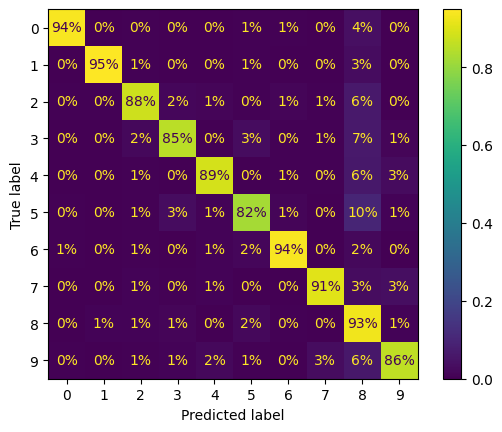

In [ ]:
#error Analysis using a colored diagram of the confusion matrix [ConfusionMatrixDisplay.from_predictions]
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred,normalize="true", values_format=".0%")

plt.show()

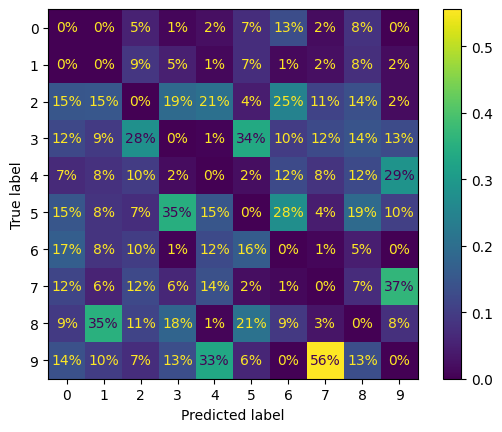

In [ ]:
sample_weight = (y_train_pred != y_train)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred,sample_weight=sample_weight, normalize="pred", values_format=".0%")

**Multiclass Multilabel Classification**

In [ ]:
# --- Method 1: by passing the Multilabel as a target to the model --
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
y_train_large = (y_train >= '7')
y_train_odd = (y_train.astype('int8') % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

knn_clf.predict([some_digit])

In [ ]:
# -- Method 2: by using 'ClassifierChain' with 'model_name',cv,random_state parameters --
from sklearn.multioutput import ClassifierChain
chain_clf = ClassifierChain(SVC(), cv=3, random_state=42)
chain_clf.fit(X_train[:2000], y_multilabel[:2000])

## **Multioutput Classification**

In [ ]:
import numpy as np
np.random.seed(42)
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise #adding noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise #adding noise

y_train_mod = X_train
y_test_mod = X_test


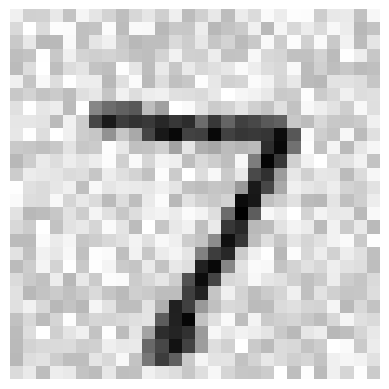

In [ ]:
plot_digit(X_test_mod[0])
plt.show()

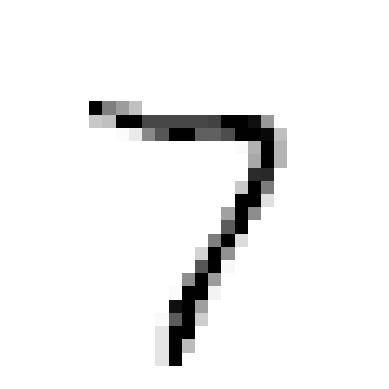

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_mod, y_train_mod)

clean_digit = knn_clf.predict([X_test_mod[0]])
plot_digit(clean_digit)

plt.show()

## **Performance measure using confusion matrix**

In [ ]:
# we first need to have a set of predictions(eg: y_train_pred) to compare them to the actual targets(y_train_5)
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_train_5, y_train_pred)

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score
precision_score(y_train_5, y_train_pred)
recall_score(y_train_5, y_train_pred)
f1_score(y_train_5, y_train_pred)


0.7325171197343846

In [ ]:
some_digit = X[0].reshape(1, -1) # Reshape to a 2D array with a single sample
y_scores = sgd_clf.decision_function(some_digit)
y_scores

array([2164.22030239])

### **deciding which threshold to use**

In [ ]:
# use "cross_val_predict" to get the scores of all instances in the training set
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
  method="decision_function")


In [ ]:

from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)


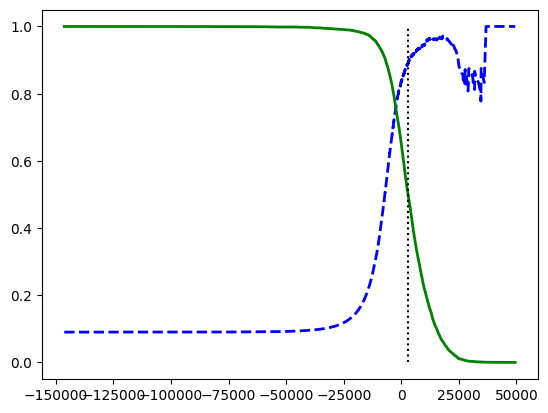

In [ ]:
# METHOD-1: by seeing the thresholds, precision,recall graph behaviour select good thresfold value
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
threshold=3000
plt.vlines(threshold, 0, 1.0, "k", "dotted", label="threshold")
plt.show()

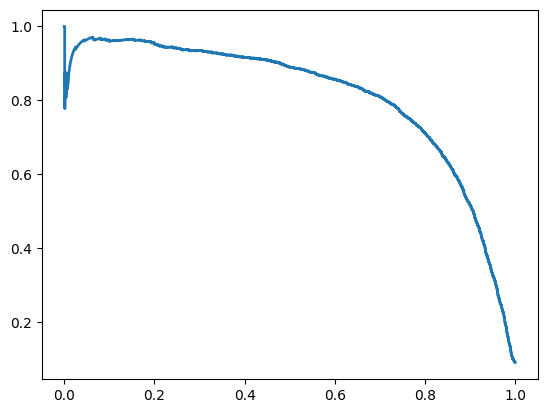

In [ ]:
# METHOD-2: by seeing recalls, precisions graph
plt.plot(recalls, precisions, linewidth=2, label="Precision/Recall curve")
plt.show()

In [ ]:
idx_for_90_precision = (precisions >= 0.90).argmax()
threshold_for_90_precision = thresholds[idx_for_90_precision]
threshold_for_90_precision

3370.0194991439557

In [ ]:
y_train_pred_90 = (y_scores >= threshold_for_90_precision)

precision_score(y_train_5, y_train_pred_90)
recall_at_90_precision = recall_score(y_train_5, y_train_pred_90)
recall_at_90_precision

0.4799852425751706

**The ROC curve**

In [ ]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

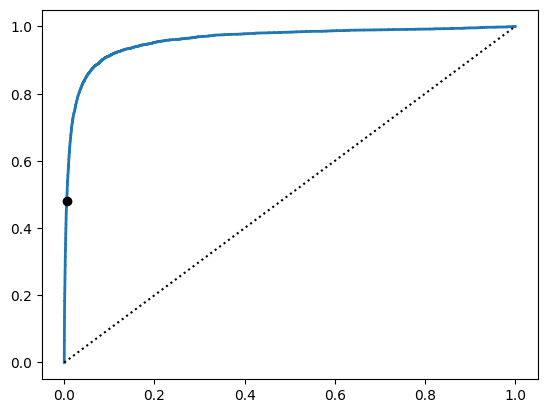

In [ ]:
idx_for_threshold_at_90 = (thresholds <= threshold_for_90_precision).argmax()
tpr_90, fpr_90 = tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90]
plt.plot(fpr, tpr, linewidth=2, label="ROC curve")
plt.plot([0, 1], [0, 1], 'k:', label="Random classifier's ROC curve") #straight line
plt.plot([fpr_90], [tpr_90], "ko", label="Threshold for 90% precision") # a point

plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score #area under the curve
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [ ]:
from sklearn.svm import SVC
svm_clf = SVC(random_state=42)
svm_clf.fit(X_train[:2000], y_train[:2000]) # y_train, not y_train_5